<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/combinedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.legend_handler import HandlerTuple
plt.set_loglevel("WARNING")

In [2]:
# set up color palette
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()

c1, c2, c3, c4, c5, c7 = (
    palett_as_hex[0],
    palett_as_hex[1],
    palett_as_hex[2],
    palett_as_hex[3],
    palett_as_hex[4],
    palett_as_hex[6],
)
c8 = matplotlib.colors.to_rgba("k", alpha=0.1)
c8_2 = matplotlib.colors.to_rgba("k", alpha=0.01)
# c5 = lila
# c7= rosa

In [3]:
data = pd.read_csv("sample_data/combinedDataset.csv")

In [4]:
def bootstrap_metric(fct, x_values, y_values, p_value=False):
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(
            range(0, len(x_values)), size=len(x_values), replace=True
        )
        x_selection = np.take(x_values, indices)
        y_selection = np.take(y_values, indices)
        if p_value:
            r = fct(x_selection, y_selection)[0]
        else:
            r = fct(x_selection, y_selection)
        bootstrapped_metric.append(r)

    # define 95% CI
    alpha = 5.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    if p_value:
        mean = fct(x_values, y_values)[0]
    else:
        mean = fct(x_values, y_values)
    return mean, lower, upper

def calculate_statistics(x_values, y_values,output=False):
    # bootstrap RMSE
    def calc_rmse(x_values, y_values):
        return np.sqrt(mean_squared_error(x_values, y_values))

    rmse_mean, rmse_lower, rmse_upper = bootstrap_metric(calc_rmse, x_values, y_values)
    if output:
      print(
        f"RMSE:  {round(rmse_mean, 2)} [{round(rmse_lower,2)}, {round(rmse_upper,2)}]"
      )

    # bootstrap MAE
    mae_mean, mae_lower, mae_upper = bootstrap_metric(
        mean_absolute_error, x_values, y_values
    )
    if output:
      print(f"MAE:  {round(mae_mean, 2)} [{round(mae_lower,2)}, {round(mae_upper,2)}]")

    # bootstrap Pearson
    pearson_mean, pearson_lower, pearson_upper = bootstrap_metric(
        scipy.stats.pearsonr, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Pearson correlation:  {round(pearson_mean, 2)} [{round(pearson_lower,2)}, {round(pearson_upper,2)}]"
      )

    # bootstrap Spearman
    spearman_mean, spearman_lower, spearman_upper = bootstrap_metric(
        scipy.stats.spearmanr, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Spearman's correlation:  {round(spearman_mean, 2)} [{round(spearman_lower,2)}, {round(spearman_upper,2)}]"
      )

    # bootstrap Kendalltau
    kendall_mean, kendall_lower, kendall_upper = bootstrap_metric(
        scipy.stats.kendalltau, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Kendalltau: {round(kendall_mean, 2)} [{round(kendall_lower,2)}, {round(kendall_upper,2)}]"
      )

    return (
        round(rmse_mean, 2),
        round(mae_mean, 2),
        round(pearson_mean, 2),
        round(spearman_mean, 2),
        round(kendall_mean, 2),
    )

Results for the **OpenFF** data

In [5]:
print(f"###### Without Corretion -- pure MM results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["MM-ASFE [kcal/mol]"])
print(f"###### Corrected results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["ML-ASFE [kcal/mol]"])

###### Without Corretion -- pure MM results ######
###### Corrected results ######


(1.92, 1.61, 0.93, 0.92, 0.76)

Results for the **CGenFF** data

In [6]:
print(f"###### Without Corretion -- pure MM results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["dG (TF) lrc"])
print(f"###### Corrected results Jar ######")
calculate_statistics(data["Exp [kcal/mol]"],data["Jar result"])

###### Without Corretion -- pure MM results ######
###### Corrected results Jar ######


(2.97, 2.14, 0.81, 0.76, 0.6)

In [7]:
data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])


In [8]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
for i in range(0,6,1):
  i = i/10
  reducedData = data.drop(data[np.abs(data['EXS correction']) < i ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['Jar correction']) < i ].index)
  ###### Without Corretion -- pure MM results ######
  rmse0,mae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["MM-ASFE [kcal/mol]"])
  Crmse0,Cmae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["dG (TF) lrc"])
  ###### Corrected results ######
  rmse1,mae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["ML-ASFE [kcal/mol]"])
  Crmse1,Cmae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Jar result"])
  CrooksRmse1,CrooksMae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Crooks result"])
  results[i] = rmse0-rmse1,len(reducedData)
  results_cgenff[i] = Crmse0-Crmse1,len(reducedData)
  results_cgenff_crooks[i] = Crmse0 - CrooksRmse1

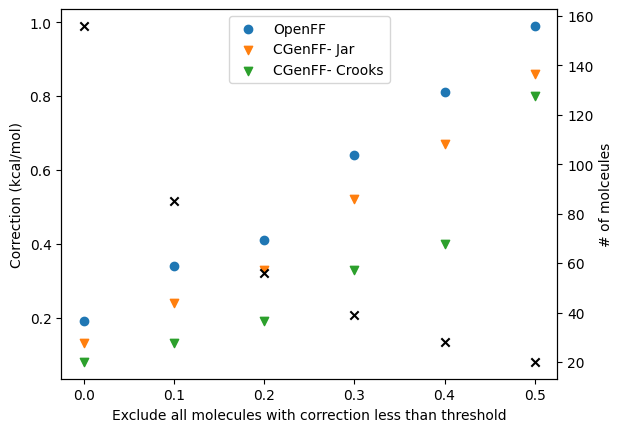

In [9]:
fig, ax1 = plt.subplots()
ax1.scatter(results.keys(),[item[0] for item in results.values()], label = "OpenFF")
ax1.scatter(results_cgenff.keys(),[item[0] for item in results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1.scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1.set_ylabel("Correction (kcal/mol)")
ax1.set_xlabel("Exclude all molecules with correction less than threshold")
ax2 = ax1.twinx()
ax2.scatter(results.keys(),[item[1] for item in results.values()],marker="x",color="black",label="# of molecules")
ax2.set_ylabel("# of molceules")
ax1.legend(frameon=True,loc="upper center")

In [10]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

In [11]:
data["MM-ML"] = np.abs(data["MM-ASFE [kcal/mol]"]-data["ML-ASFE [kcal/mol]"])

In [12]:
data.loc[:, "numRotBonds"] = np.nan

numRotBonds = {}
for index, row in data.iterrows():
    try:
      smi = row[" SMILES"].strip()
      correction = row["MM-ML"]
      mol = Chem.MolFromSmiles(smi)
      # display(mol)
      rotBonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
      data.loc[index, "numRotBonds"] = rotBonds
      # print(rotBonds)
      try:
          numRotBonds[rotBonds].append(correction)

      except KeyError:
          numRotBonds[rotBonds] = []
          numRotBonds[rotBonds].append(correction)
    except AttributeError:
      pass

In [48]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
for i in range(0,8):
  reducedData = data.drop(data[data['numRotBonds'] < i ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['Jar correction']) < 0.1 ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['EXS correction']) < 0.1 ].index)
  ###### Without Corretion -- pure MM results ######
  rmse0,mae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["MM-ASFE [kcal/mol]"])
  Crmse0,Cmae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["dG (TF) lrc"])
  ###### Corrected results ######
  rmse1,mae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["ML-ASFE [kcal/mol]"])
  Crmse1,Cmae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Jar result"])
  CrooksRmse1,CrooksMae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Crooks result"])
  # results[i] = rmse0-rmse1,len(reducedData)
  # results_cgenff[i] = Crmse0-Crmse1,len(reducedData)
  # results_cgenff_crooks[i] = Crmse0 - CrooksRmse1
  results[i] = mae0-mae1,len(reducedData)
  results_cgenff[i] = mae0-Cmae1,len(reducedData)
  results_cgenff_crooks[i] = Cmae0 - CrooksMae1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation co

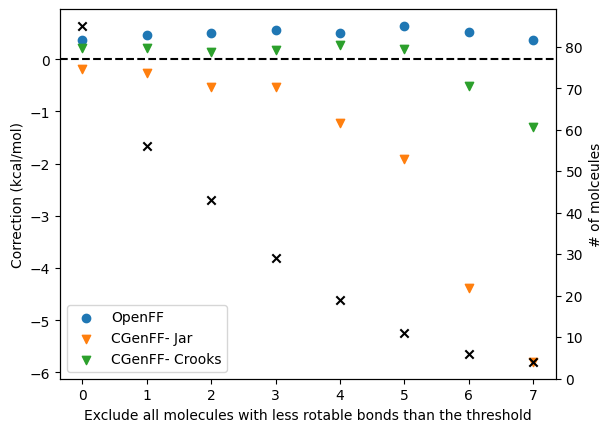

In [14]:
fig, ax1 = plt.subplots()
ax1.scatter(results.keys(),[item[0] for item in results.values()], label = "OpenFF")
ax1.scatter(results_cgenff.keys(),[item[0] for item in results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1.scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1.set_ylabel("Correction (kcal/mol)")
ax1.set_xlabel("Exclude all molecules with less rotable bonds than the threshold")
ax2 = ax1.twinx()
ax2.scatter(results.keys(),[item[1] for item in results.values()],marker="x",color="black",label="# of molecules")
ax2.set_ylabel("# of molceules")
ax1.legend(frameon=True,loc="lower left")
ax1.axhline(0,color="black",linestyle="dashed")

In [64]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}

for i in range(0,6,1):
  i = i/10
  reducedData = data.drop(data[np.abs(data['EXS correction']) < i ].index)

  rightDirection = 0
  wrongDirection = 0

  for index,row in reducedData.iterrows():
    deviation_mm = (np.abs(row["MM-ASFE [kcal/mol]"]-row["Exp [kcal/mol]"]))
    deviation_corrected = (np.abs(row["ML-ASFE [kcal/mol]"]-row["Exp [kcal/mol]"]))
    if deviation_mm > deviation_corrected:
      rightDirection += 1
    else:
      wrongDirection += 1

    results[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)

    rightDirection = 0
    wrongDirection = 0

    for index,row in reducedData.iterrows():
      deviation_mm = (np.abs(row["dG (TF) lrc"]-row["Exp [kcal/mol]"]))
      deviation_corrected = (np.abs(row["Jar result"]-row["Exp [kcal/mol]"]))
      if deviation_mm > deviation_corrected:
        rightDirection += 1
      else:
        wrongDirection += 1

      results_cgenff[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)

    rightDirection = 0
    wrongDirection = 0

    for index,row in reducedData.iterrows():
      deviation_mm = (np.abs(row["dG (TF) lrc"]-row["Exp [kcal/mol]"]))
      deviation_corrected = (np.abs(row["Crooks result"]-row["Exp [kcal/mol]"]))
      if deviation_mm > deviation_corrected:
        rightDirection += 1
      else:
        wrongDirection += 1

      results_cgenff_crooks[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)


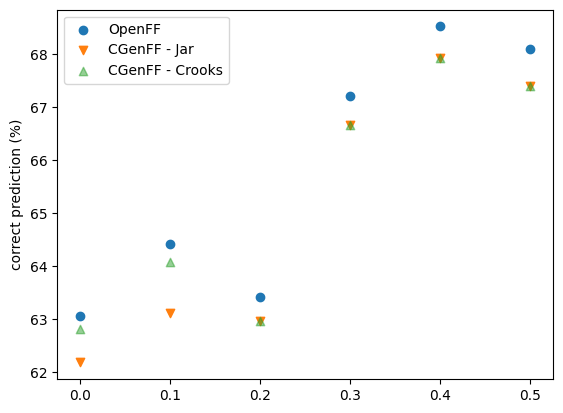

In [68]:
fig, ax1 = plt.subplots()
ax1.scatter(results.keys(),results.values(), label = "OpenFF")
ax1.scatter(results_cgenff.keys(),results_cgenff.values(),marker ="v", label = "CGenFF - Jar")
ax1.scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(),marker ="^", label = "CGenFF - Crooks",alpha=0.5)
ax1.set_ylabel("correct prediction (%)")
ax1.legend()